In [2]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# torch utils
# from torch import argmax
from torch.utils.data.dataloader import DataLoader
# torchvision
import torchvision

# utils
from tqdm import tqdm
from typing import List, Dict

# classic ml libs
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


## Оглавление
- [Вариант 2](#Вариант-2)
  - [Подготовливаем данные](#Подготовливаем-данные)
  - [Оборачиваем в даталоудеры](#Оборачиваем-в-даталоудеры)
  - [Создаем архитектуру (***padding*** = 0 в первом слое)](#Создаем-архитектуру-(***padding***-=-0-в-первом-слое))
  - [Создаем архитектуру, в которой восстановлен ***padding*** в первом слое](#Создаем-архитектуру,-в-которой-восстановлен-***padding***-в-первом-слое)
  - [Создаем функции для обучения и валидации сети](#Создаем-функции-для-обучения-и-валидации-сети)
- [Вариант 3. Контроль количества параметров](#Вариант-3.-Контроль-количества-параметров)


### Вариант 2


#### 

**Цель: Контроль пространственных размерностей через свертки и пулинг.**

1. Спроектируйте сеть для выхода (64, 16, 16) за не более 3 слоев свертки.

2. Условие: Используйте как минимум один слой с padding=0, чтобы часть пространственной информации была потеряна. Можно менять в таких условиях kernel_size и stride.

*Эксперимент: Сравните выход с использованием padding=0 и padding=1, оцените разницу в размерности и среднее значение активаций.*

#### Подготовливаем данные

Загружаем тестовую и тренировочную выборку

In [4]:
train_data = torchvision.datasets.CIFAR10(root=r'../data', train=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.CIFAR10(root=r'../data', train=False, transform=torchvision.transforms.ToTensor())
print(len(train_data), len(test_data))

50000 10000


In [5]:
train_size = int(len(train_data) * 0.8)
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Оборачиваем в даталоудеры

In [6]:
train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

#### Создаем архитектуру (***padding*** = 0 в первом слое)

In [69]:
class HomeworkNet_0(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, padding=1)
        self.fc1 = nn.Linear(in_features=64, out_features=10) # in_features = 64*1*1 (так как используем GAP)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.drop = nn.Dropout(p=0.3)
        self.bn_conv1 = nn.BatchNorm2d(num_features=16)
        self.bn_conv2 = nn.BatchNorm2d(num_features=32)
        self.bn_conv3 = nn.BatchNorm2d(num_features=64)
        # ReLU используем как F.ReLU
        # softmax зашита в CrossEntropyLoss

    def forward(self, x):
        # conv1
        x = self.conv1(x)
        x = F.relu(self.bn_conv1(x))
        # print("After conv1:", x.shape)
        # print("Среднее значение активаций:", x.mean().item())
        
        # conv2
        x = self.conv2(x)
        x = F.relu(self.bn_conv2(x))
        # print("After conv2:", x.shape)
        # print("Среднее значение активаций:", x.mean().item())

        # conv3
        x = self.conv3(x)
        x = F.relu(self.bn_conv3(x))
        # print("After conv3:", x.shape)
        # print("Среднее значение активаций:", x.mean().item())

        # gap + fc1 
        x = self.drop(x)
        x = self.gap(x)
        # print("After GAP:", x.shape)
        # print("Среднее значение активаций:", x.mean().item())
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

Создаем архитектуру, в которой восстановлен ***padding*** в первом слое

In [ ]:
class HomeworkNet_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, padding=1)
        self.fc1 = nn.Linear(in_features=64, out_features=10) # in_features = 64*1*1 (так как используем GAP)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.drop = nn.Dropout(p=0.3)
        self.bn_conv1 = nn.BatchNorm2d(num_features=16)
        self.bn_conv2 = nn.BatchNorm2d(num_features=32)
        self.bn_conv3 = nn.BatchNorm2d(num_features=64)


    def forward(self, x):
        # conv1
        x = self.conv1(x)
        x = F.relu(self.bn_conv1(x))
        # print("Размерность после conv1:", x.shape)
        # print("Среднее значение активаций:", x.mean().item())

        # conv2
        x = self.conv2(x)
        x = F.relu(self.bn_conv2(x))
        # print("Размерность после conv2:", x.shape)
        # print("Среднее значение активаций:", x.mean().item())
        
        # conv3
        x = self.conv3(x)
        x = F.relu(self.bn_conv3(x))
        # print("Размерность после conv3:", x.shape)
        # print("Среднее значение активаций:", x.mean().item())
        
        # gap + fc1 
        x = self.drop(x)
        x = self.gap(x)
        # print("Размерность после GAP:", x.shape)
        # print("Среднее значение активаций:", x.mean().item())
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [68]:
model = HomeworkNet_0()
x = torch.randn(1, 3, 32, 32)
out = model(x)

After conv1: torch.Size([1, 16, 24, 24])
Среднее значение активаций: 0.39624857902526855
After conv2: torch.Size([1, 32, 20, 20])
Среднее значение активаций: 0.4000762104988098
After conv3: torch.Size([1, 64, 16, 16])
Среднее значение активаций: 0.3992786109447479
After GAP: torch.Size([1, 64, 1, 1])
Среднее значение активаций: 0.40319645404815674


In [53]:
model = HomeworkNet_1()
x = torch.randn(1, 3, 32, 32)
out = model(x)

Размерность после conv1: torch.Size([1, 16, 26, 26])
Среднее значение активаций: 0.3983019292354584
Размерность после conv2: torch.Size([1, 32, 22, 22])
Среднее значение активаций: 0.3987589180469513
Размерность после conv3: torch.Size([1, 64, 18, 18])
Среднее значение активаций: 0.3987939655780792
Размерность после GAP: torch.Size([1, 64, 1, 1])
Среднее значение активаций: 0.3996787965297699


#### Создаем функции для обучения и валидации сети

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomeworkNet_0()
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=5e-4)

In [11]:
next(iter(train_dataloader))[0]

tensor([[[[0.5725, 0.5647, 0.5961,  ..., 0.5255, 0.5765, 0.5294],
          [0.5725, 0.5412, 0.5961,  ..., 0.5569, 0.5922, 0.4353],
          [0.5882, 0.5255, 0.6157,  ..., 0.5020, 0.5725, 0.3961],
          ...,
          [0.3961, 0.3647, 0.3647,  ..., 0.4078, 0.4196, 0.4314],
          [0.4392, 0.4314, 0.4392,  ..., 0.3451, 0.3647, 0.3804],
          [0.4745, 0.4863, 0.4863,  ..., 0.3216, 0.3255, 0.3490]],

         [[0.5569, 0.5529, 0.5843,  ..., 0.5176, 0.5451, 0.5255],
          [0.5647, 0.5373, 0.5882,  ..., 0.5608, 0.5922, 0.4627],
          [0.5882, 0.5255, 0.6157,  ..., 0.5176, 0.5961, 0.4510],
          ...,
          [0.4039, 0.3725, 0.3725,  ..., 0.4157, 0.4353, 0.4471],
          [0.4353, 0.4314, 0.4392,  ..., 0.3569, 0.3804, 0.4000],
          [0.4667, 0.4784, 0.4784,  ..., 0.3333, 0.3451, 0.3686]],

         [[0.5529, 0.5294, 0.5686,  ..., 0.5216, 0.5608, 0.5333],
          [0.5725, 0.5255, 0.5843,  ..., 0.5608, 0.6157, 0.4706],
          [0.5961, 0.5137, 0.6118,  ..., 0

In [12]:
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    accuracy = (preds == y).float().mean().item()
    return accuracy


In [14]:
def get_mean_loss_per_epoch(loss_list):
    mean_epoch_losses = []
    for epoch_losses in loss_list:
        if len(epoch_losses) == 0:
            continue
        mean_epoch_losses.append(float(np.mean(epoch_losses)))
    return mean_epoch_losses

In [15]:
def visualize_test_loss(test_loss_list):
    mean_loss = get_mean_loss_per_epoch(test_loss_list)
    if len(mean_loss) == 0:
        return
    epochs = np.arange(1, len(mean_loss) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_loss, label="Test loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Test Loss per Epoch")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [16]:
def visualize_train_val_loss_dynamic(train_loss_list, valid_loss_list):
    train_mean_epoch_loss = get_mean_loss_per_epoch(train_loss_list)
    valid_mean_epoch_loss = get_mean_loss_per_epoch(valid_loss_list)
    if len(train_mean_epoch_loss) == 0 and len(valid_mean_epoch_loss) == 0:
        return
    epochs_train = np.arange(1, len(train_mean_epoch_loss) + 1)
    epochs_val = np.arange(1, len(valid_mean_epoch_loss) + 1)
    plt.figure(figsize=(10, 6))
    if len(train_mean_epoch_loss) > 0:
        plt.plot(epochs_train, train_mean_epoch_loss, label="Train loss", linewidth=2)
    if len(valid_mean_epoch_loss) > 0:
        plt.plot(epochs_val, valid_mean_epoch_loss, label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss per Epoch")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [17]:
def train(model, train_dataloader, val_dataloader, device, loss_function, optimizer, num_epochs: int = 10) -> Dict[str, Dict[str, List[float]]]:
    model.to(device)
    train_loss_per_epochs = []
    valid_loss_per_epochs = []

    for epoch in tqdm(range(num_epochs)):
        # Тренировка
        model.train()
        train_loss_in_epoch = []
        for _, batch in tqdm(enumerate(train_dataloader)):
            x_train_batch = batch[0].to(device)
            y_train_batch = batch[1].to(device)

            optimizer.zero_grad()

            train_output = model(x_train_batch)
            train_loss = loss_function(train_output, y_train_batch)
            train_loss_in_epoch.append(train_loss.detach().cpu().item())

            train_loss.backward()
            optimizer.step()

        train_loss_per_epochs.append(train_loss_in_epoch)

        print(f"Loss на эпохе {epoch} равeн {train_loss}")

        # Валидация
        val_loss_in_epoch = []
        model.eval()
        with torch.no_grad():
            for _, val_batch in tqdm(enumerate(val_dataloader)):
                x_val_batch = val_batch[0].to(device)
                y_val_batch = val_batch[1].to(device)

                val_output = model(x_val_batch)
                val_loss = loss_function(val_output, y_val_batch)
                val_loss_in_epoch.append(val_loss.detach().cpu().item())
                
        valid_loss_per_epochs.append(val_loss_in_epoch)
    
    visualize_train_val_loss_dynamic(train_loss_list=train_loss_per_epochs, valid_loss_list=valid_loss_per_epochs)

  

    return {'train_loss': train_loss_per_epochs, 'valid_loss': valid_loss_per_epochs}

In [18]:
def evaluate(model, dataloader, device) -> Dict[str, float]:
    model.to(device)
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.detach().cpu())
            all_targets.append(labels.detach().cpu())

    if len(all_preds) == 0:
        return {"accuracy": 0.0, "f1_macro": 0.0, "f1_weighted": 0.0}

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()

    metrics = {
        "accuracy": accuracy_score(y_true=y_true, y_pred=y_pred),
        "f1_macro": f1_score(y_true=y_true, y_pred=y_pred, average="macro"),
        "f1_weighted": f1_score(y_true=y_true, y_pred=y_pred, average="weighted"),
    }
    return metrics


625it [00:08, 74.18it/s]0:00<?, ?it/s]


Loss на эпохе 0 равeн 1.4885669946670532


313it [00:01, 166.93it/s]
625it [00:08, 77.14it/s]0:10<04:59, 10.31s/it]


Loss на эпохе 1 равeн 1.2581456899642944


313it [00:01, 159.71it/s]
625it [00:08, 77.85it/s]0:20<04:44, 10.17s/it]


Loss на эпохе 2 равeн 1.028664469718933


313it [00:01, 162.17it/s]
625it [00:07, 78.69it/s]0:30<04:32, 10.08s/it]


Loss на эпохе 3 равeн 1.080726981163025


313it [00:01, 164.22it/s]
625it [00:07, 80.22it/s]0:40<04:19,  9.99s/it]


Loss на эпохе 4 равeн 0.9943902492523193


313it [00:01, 165.08it/s]
625it [00:07, 80.03it/s]0:49<04:07,  9.89s/it]


Loss на эпохе 5 равeн 1.4654319286346436


313it [00:01, 163.62it/s]
625it [00:07, 78.19it/s]0:59<03:56,  9.83s/it]


Loss на эпохе 6 равeн 0.9561650156974792


313it [00:01, 163.19it/s]
625it [00:07, 79.53it/s]1:09<03:46,  9.86s/it]


Loss на эпохе 7 равeн 0.882319986820221


313it [00:01, 166.49it/s]
625it [00:07, 80.26it/s]1:19<03:36,  9.83s/it]


Loss на эпохе 8 равeн 1.0390594005584717


313it [00:01, 165.43it/s]
625it [00:07, 79.55it/s]1:29<03:25,  9.78s/it]


Loss на эпохе 9 равeн 0.9825742244720459


313it [00:01, 162.60it/s]
625it [00:07, 79.21it/s]01:38<03:15,  9.79s/it]


Loss на эпохе 10 равeн 0.8534240126609802


313it [00:01, 164.56it/s]
625it [00:07, 79.77it/s]01:48<03:06,  9.79s/it]


Loss на эпохе 11 равeн 1.0290579795837402


313it [00:01, 164.65it/s]
625it [00:07, 79.69it/s]01:58<02:56,  9.78s/it]


Loss на эпохе 12 равeн 0.8853621482849121


313it [00:01, 164.39it/s]
625it [00:07, 79.68it/s]02:08<02:46,  9.77s/it]


Loss на эпохе 13 равeн 0.6833378076553345


313it [00:01, 165.26it/s]
625it [00:07, 80.16it/s]02:17<02:36,  9.76s/it]


Loss на эпохе 14 равeн 0.7933487296104431


313it [00:01, 164.91it/s]
625it [00:07, 80.14it/s]02:27<02:26,  9.75s/it]


Loss на эпохе 15 равeн 0.9922617077827454


313it [00:01, 165.87it/s]
625it [00:07, 80.14it/s]02:37<02:16,  9.73s/it]


Loss на эпохе 16 равeн 0.9038385152816772


313it [00:01, 165.78it/s]
625it [00:07, 79.65it/s]02:46<02:06,  9.72s/it]


Loss на эпохе 17 равeн 0.8332391977310181


313it [00:01, 164.22it/s]
625it [00:07, 79.55it/s]02:56<01:56,  9.74s/it]


Loss на эпохе 18 равeн 0.7516189217567444


313it [00:01, 164.82it/s]
625it [00:07, 79.66it/s]03:06<01:47,  9.75s/it]


Loss на эпохе 19 равeн 1.0433545112609863


313it [00:01, 166.76it/s]
625it [00:07, 78.39it/s]03:16<01:37,  9.74s/it]


Loss на эпохе 20 равeн 1.0209472179412842


313it [00:01, 162.68it/s]
625it [00:08, 76.91it/s]03:26<01:28,  9.79s/it]


Loss на эпохе 21 равeн 0.9080256819725037


313it [00:01, 162.26it/s]
625it [00:07, 79.34it/s]03:36<01:18,  9.87s/it]


Loss на эпохе 22 равeн 0.8892071843147278


313it [00:01, 157.68it/s]
625it [00:08, 76.70it/s]03:46<01:09,  9.87s/it]


Loss на эпохе 23 равeн 0.668797492980957


313it [00:02, 141.44it/s]
625it [00:08, 74.43it/s]03:56<01:00, 10.02s/it]


Loss на эпохе 24 равeн 0.6982715129852295


313it [00:02, 153.35it/s]
625it [00:08, 77.31it/s]04:06<00:50, 10.15s/it]


Loss на эпохе 25 равeн 1.0018830299377441


313it [00:01, 159.04it/s]
625it [00:07, 80.01it/s]04:16<00:40, 10.13s/it]


Loss на эпохе 26 равeн 0.7069608569145203


313it [00:01, 165.59it/s]
625it [00:07, 80.07it/s]04:26<00:30, 10.00s/it]


Loss на эпохе 27 равeн 0.5738921165466309


313it [00:01, 165.96it/s]
625it [00:07, 79.82it/s]04:36<00:19,  9.91s/it]


Loss на эпохе 28 равeн 0.6553390026092529


313it [00:01, 166.22it/s]
625it [00:07, 79.74it/s]04:46<00:09,  9.86s/it]


Loss на эпохе 29 равeн 0.8660407066345215


313it [00:01, 165.61it/s]
100%|██████████| 30/30 [04:55<00:00,  9.86s/it]


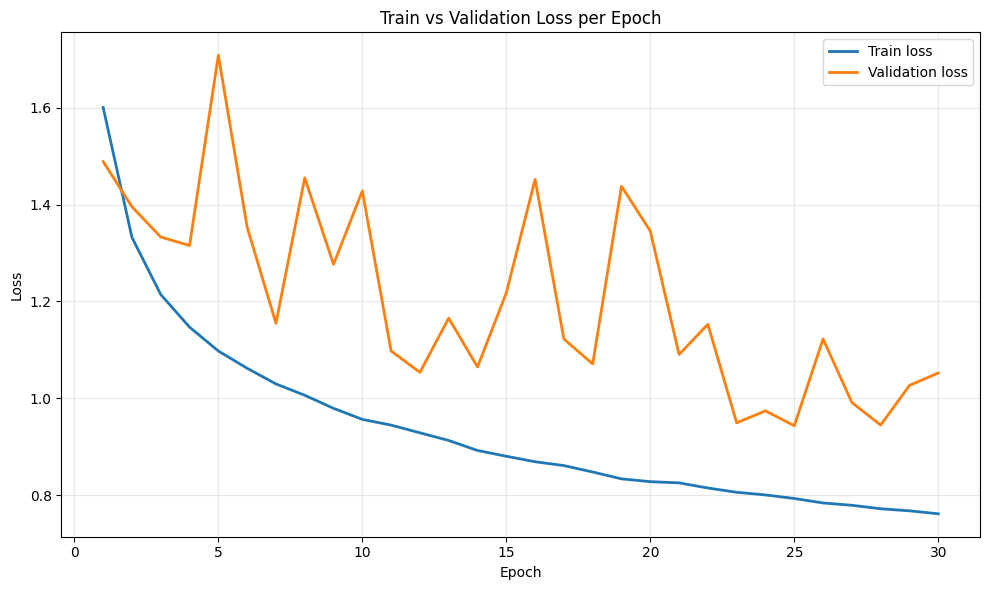

In [41]:
train_val_metrics = train(model=model, 
                          train_dataloader=train_dataloader, 
                          val_dataloader=val_dataloader,
                          device=device, 
                          loss_function=loss_func, 
                          optimizer=opt, 
                          num_epochs=30)

In [42]:
test_metrics = evaluate(model=model, dataloader=test_dataloader, device=device)
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"F1 (macro): {test_metrics['f1_macro']:.4f}")
print(f"F1 (weighted): {test_metrics['f1_weighted']:.4f}")


100%|██████████| 313/313 [00:02<00:00, 140.30it/s]

Accuracy: 0.6521
F1 (macro): 0.6411
F1 (weighted): 0.6411


### Вариант 3. Контроль количества параметров

**Цель: Создание компактной сети.**

Создайте архитектуру, используя не более 50 000 параметров.
Условие: Один слой должен быть 1x1 сверткой, чтобы уменьшить число каналов.

*Эксперимент: Подсчитайте количество параметров каждого слоя и убедитесь, что общая сумма не превышает лимита.*

In [95]:
class HomeworkNet_compact(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=64,
            kernel_size=3,
            padding=0 # 16 -> 14
        )
        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=8,
            kernel_size=1
        )
        self.conv4 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            padding=1
        )
        self.bn_conv1 = nn.BatchNorm2d(num_features=16)
        self.bn_conv2 = nn.BatchNorm2d(num_features=64)
        self.bn_conv3 = nn.BatchNorm2d(num_features=8)
        self.bn_conv4 = nn.BatchNorm2d(num_features=16)
        self.mxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=3136, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mxp1(x) # 32 -> 16 
        x = F.relu(self.bn_conv1(x))

        x = self.conv2(x)
        x = F.relu(self.bn_conv2(x))

        x = self.conv3(x)
        x = F.relu(self.bn_conv3(x))

        x = self.conv4(x)
        x = F.relu(self.bn_conv4(x))

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

In [96]:
model2 = HomeworkNet_compact()

#### Проверяем условие по количеству параметров

In [102]:
assert sum([param.numel() for param in model2.parameters()]) <= 50000, "Количество параметров вышло за рамки установленного лимита"
sum([param.numel() for param in model2.parameters()])

42994